# Business Understanding
We hebben een dataset gekregen die bestaat uit strafbare feiten van de stad Denver van de afgelopen vijf jaar. De gegevens komen van het National Incident Based Reporting System (NIBRS). 

### User stories
- <b>Als gemeente wil ik een overzicht zien van het aantal misdaden per wijk zodat de politiecapaciteit beter verdeeld kan worden.</b>
    - Sortering van hoog naar laag (extra de wijk met het aantal meldingen)
    - Per wijk het aantal misdaden.
    - Heatmap groen weinig/ rood veel (vergeet niet de labels)
    

- Als gemeente wil ik per type misdaad zien in welke wijk deze het meest voor komen zodat dit type misdaden gericht aangepakt kunnen worden.
    - Weergeven in een staafdiagram per type misdaad 
    - Uitschieters per type misdaad 
    - Het gemiddelde van de misdaden per het aantal inwoners in een wijk. 


- Als gemeente wil ik weten waar de meeste (top 5) verkeersincidenten plaatsvinden zodat er eventueel een aanpassing gemaakt kan worden in de infrastructuur.
    - Op een kaart weergeven waar het incident plaats vindt. 
    - Op de kaart het aantal incidenten weergeven. 
    - Als geen top 5 uitkomt geef dan de wijk aan waar de meeste verkeersincidenten plaatsvinden 
    
    
- Als gemeente wil ik inzicht krijgen of de criminaliteit de afgelopen 5 jaar gestegen is met daarbij een voorspelling voor de komende 5 jaar zodat de gemeente weet of ze genoeg politiecapaciteit hebben voor de komende jaren. 
    - Berekend het aantal misdaden per jaar. 
    - Kijk goed naar wanneer er begonnen is met het registeren van de misdaden. 
    - Bereken de correlatiecoëfficiënt 
    - Geef het lineaire verband weer in een spreidingsdiagram met lijn 
    
    
- Als gemeente wil ik inzicht in per type misdaad of deze in bepaalde seizoenen meer voor voorkomen dan in andere seizoenen zodat de gemeente de politie voortijdig kan voorbereiden. 
    - Per seizoen het aantal misdaden per type misdaad in een lijndiagram. 
    


# Data Understanding

In [1]:
# importeer je packages
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

## Collect initial data
De data is aan ons aangeleverd in de vorm van twee .csv bestanden. Deze zijn met elkaar gekoppeld aan de hand van de identieke kolomnamen ‘offense_code’. Andere interessante gegevens zijn de datum en plaats waar en wanneer het strafbare feit is gepleegd. Met name de verkeersincidenten zijn in Denver erg hoog, we zullen specifiek voor de verkeersincidenten extra analyses doen.

In [2]:
df_crime = pd.read_csv('crime.csv', parse_dates=[
    'FIRST_OCCURRENCE_DATE',
    'LAST_OCCURRENCE_DATE',
    'REPORTED_DATE'
], dtype={
    'IS_CRIME': 'bool',
    'IS_TRAFFIC': 'bool'
})
#df_offense_codes = pd.read_csv('offense_codes.csv')

## Describe data

In [3]:
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454540 entries, 0 to 454539
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   INCIDENT_ID             454540 non-null  int64         
 1   OFFENSE_ID              454540 non-null  int64         
 2   OFFENSE_CODE            454540 non-null  int64         
 3   OFFENSE_CODE_EXTENSION  454540 non-null  int64         
 4   OFFENSE_TYPE_ID         454540 non-null  object        
 5   OFFENSE_CATEGORY_ID     454540 non-null  object        
 6   FIRST_OCCURRENCE_DATE   454540 non-null  datetime64[ns]
 7   LAST_OCCURRENCE_DATE    152118 non-null  datetime64[ns]
 8   REPORTED_DATE           454540 non-null  datetime64[ns]
 9   INCIDENT_ADDRESS        414371 non-null  object        
 10  GEO_X                   450607 non-null  float64       
 11  GEO_Y                   450607 non-null  float64       
 12  GEO_LON                 450606

0. **INCIDENT_ID :** Bestaat uit een combinatie van INCIDENT_ID, OFFENSE_CODE en OFFENSE_CODE_EXTENSION. Dit zorgt ervoor dat iedere overtreding uniek identificeerbaar is.
1. **OFFENSE_ID:** Unieke integer voor iedere melding. Zo kan het bijvoorbeeld voorkomen dat er meerdere overtredingen worden gepleegd per melding
2. **OFFENSE_CODE:** De code waarmee verwezen wordt naar een algemene soort overtreding. In combinatie met
3. **OFFENSE_CODE_EXTENSION:** kan het specifieke misdrijf worden achterhaald.Een uitbreiding op OFFENSE_CODE. Geeft een specifiek misdrijf aan (ander CSV-bestand).
4. **OFFENSE_TYPE_ID:** Geeft de naam van het misdrijf weer. Bijvoorbeeld een aanrijding onder invloed, heroïnegebruik, etc.
5. **OFFENSE_CATEGORY_ID:** Geeft de basisnaam van het misdrijf weer. Een generalisatie van OFFENSE_TYPE_ID. Zo valt het gebruik van zowel heroïne als wiet onder het algemene misdrijf ‘drugsgebruik’.
6. **FIRST_OCCURRENCE_DATE:** De eerst mogelijk datum van het incident.
7. **LAST_OCCURRENCE_DATE:** als de FIRST_OCCURRENCE_DATE en de LAST_OCCURRENCE_DATE kolommen beide zijn ingevulgd dan is er een schatting gemaakt van het incident
8. **REPORTED_DATE:** datum waarop het delict werd gerapporteerd
9. **INCIDENT_ADDRESS:** de straat waar het incident heeft plaats gevonden. Deze kolom is niet altijd ingevuld in verband met privacy.
10. **GEO_X:** Geografische coördinaten
11. **GEO_Y:** GEO_Y
12. **GEO_LON:** lengtegraad
13. **GEO_LAT:** breedtegraad
14. **DISTRICT_ID:** Afgebakend geografisch gebied in Denver.
15. **PRECINCT_ID:** Het id van het gebied waar het incident is afgerond?
16. **NEIGHBORHOOD_ID:** buurt waarin het delict plaatsvond
17. **IS_CRIME:** Was het incident een misdaad?
18. **IS_TRAFFIC:** Was het incident een verkeersincident?

Wat ons opvalt aan kolommen waarin een datum hoort te staat dat ze van het type object zijn. Wij hebben bij het inporteren van het CSV-bestand dan ook het type aangepast naar een date. Daarnaast hebben wij de kolommen van IS_CRIME en IS_TRAFFIC aangepast naar een boolean.

In [4]:
df_crime.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
INCIDENT_ID,454540.0,4.207075e+09,1.457081e+10,2.019600e+04,2.016748e+09,2.018438e+09,2.020122e+09,2.020890e+12
OFFENSE_ID,454540.0,4.207075e+15,1.457081e+16,2.019652e+10,2.016748e+15,2.018438e+15,2.020122e+15,2.020890e+18
OFFENSE_CODE,454540.0,3.715744e+03,1.647371e+03,9.020000e+02,2.305000e+03,2.999000e+03,5.441000e+03,7.399000e+03
OFFENSE_CODE_EXTENSION,454540.0,2.070577e-01,5.784915e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00
GEO_X,450607.0,3.165068e+06,7.114081e+05,1.000000e+00,3.138868e+06,3.145749e+06,3.163062e+06,4.067477e+07
GEO_Y,450607.0,1.695826e+06,2.323741e+05,1.000000e+00,1.683238e+06,1.694794e+06,1.701977e+06,1.046707e+08
GEO_LON,450606.0,-1.049235e+02,1.985000e+00,-1.154641e+02,-1.050062e+02,-1.049818e+02,-1.049203e+02,5.000000e-07
GEO_LAT,450606.0,3.971875e+01,7.516972e-01,0.000000e+00,3.970800e+01,3.973981e+01,3.975958e+01,3.990431e+01
DISTRICT_ID,454539.0,3.528043e+00,1.782229e+00,1.000000e+00,2.000000e+00,3.000000e+00,5.000000e+00,7.000000e+00
PRECINCT_ID,454539.0,3.703956e+02,1.790605e+02,1.110000e+02,2.210000e+02,3.230000e+02,5.210000e+02,7.590000e+02


Wat kunnen afleiden uit de volgende tabel:
- Er zijn **454545** incident meldingen geregisteerd.

### Explore data

# Data Preparation
## Select Data
Voor het maken van een staafdiagram om de misdaden per buurt te tellen hebben we de volgende kolommen nodig: `NEIGHBORHOOD_ID`. Hierbij tellen we per buurt hoeveel deze voorkomt in de dataset. Immers, elk record is een incident. Voor het maken van de heatmap gebruiken we de kolommen `GEO_LAT`, `GEO_LON`, en `OFFENSE_CATEGORY_ID`.

## Clean data
Wegens privacy redenen zijn bevatten sommige records geen `GEO_LAT` en `GEO_LON` waardes. Daarom gebruiken we voor de heatmap alleen de records waarbij deze kolommen wél gevuld zijn:

In [5]:
df_crime=df_crime.dropna(subset=['GEO_LAT','GEO_LON'])
df_crime.isnull().sum()

INCIDENT_ID                    0
OFFENSE_ID                     0
OFFENSE_CODE                   0
OFFENSE_CODE_EXTENSION         0
OFFENSE_TYPE_ID                0
OFFENSE_CATEGORY_ID            0
FIRST_OCCURRENCE_DATE          0
LAST_OCCURRENCE_DATE      300643
REPORTED_DATE                  0
INCIDENT_ADDRESS           36236
GEO_X                          0
GEO_Y                          0
GEO_LON                        0
GEO_LAT                        0
DISTRICT_ID                    0
PRECINCT_ID                    0
NEIGHBORHOOD_ID                0
IS_CRIME                       0
IS_TRAFFIC                     0
dtype: int64

## Integrate Data
We gebruiken slechts één dataset en daarom integreren we geen verdere data.

## Format Data
De data is aangeleverd in een formaat die wij kunnen gebruiken voor analyse. We formatteren de data niet.


# Modeling

five-points     24395
central-park    20237
capitol-hill    16326
cbd             15300
montbello       15252
Name: NEIGHBORHOOD_ID, dtype: int64


<AxesSubplot:title={'center':'Misdaden per buurt'}>

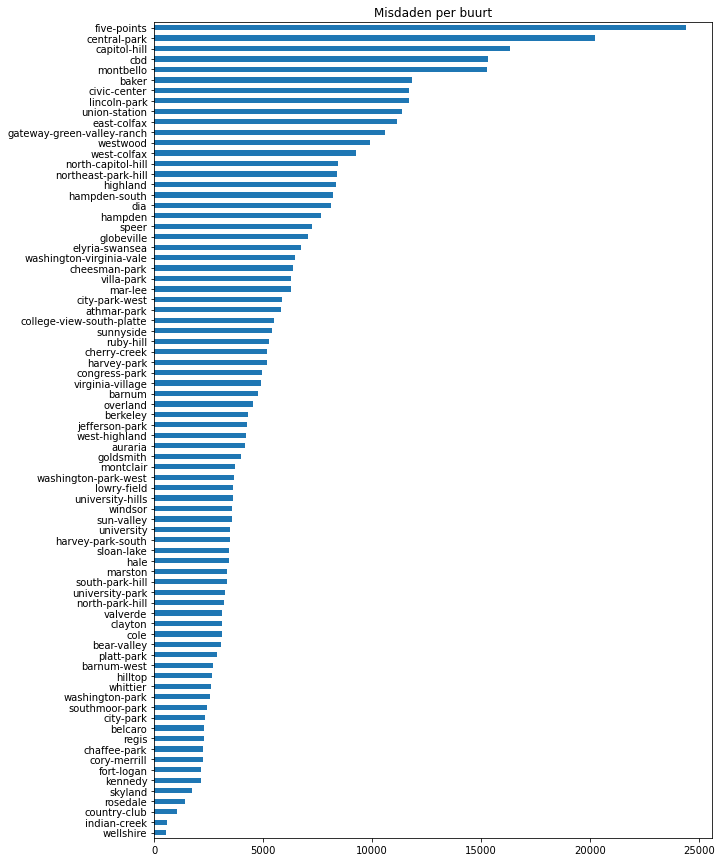

In [6]:
# Doorvoeren naamsverandering van de wij Stapleton naar Central Park
df_crime["NEIGHBORHOOD_ID"] = df_crime["NEIGHBORHOOD_ID"].replace("stapleton", "central-park")

top_5 = df_crime['NEIGHBORHOOD_ID'].value_counts()[:5]
last_5 = df_crime['NEIGHBORHOOD_ID'].value_counts()[:-1]
print(top_5)

df_crime['NEIGHBORHOOD_ID'].value_counts().sort_values(ascending=True).plot(kind='barh', 
                                                                               title='Misdaden per buurt', figsize=(10, 15))


In [7]:
import folium
from folium import plugins


data_2000=df_crime[:2000]
Long=data_2000.GEO_LON.mean()
Lat=data_2000.GEO_LAT.mean()
data_map=folium.Map([Lat,Long],zoom_start=12)
data_crime_map=plugins.MarkerCluster().add_to(data_map)

for lat,lon,label in zip(data_2000.GEO_LAT,data_2000.GEO_LON,data_2000.OFFENSE_CATEGORY_ID):
    folium.Marker(location=[lat,lon],icon=None,popup=label).add_to(data_crime_map)
data_map.add_child(data_crime_map)

data_map


# Evaluation
**Vul dit stuk aan: wat betekenen deze resultaten in het licht van de originele Business Understanding?**
Met de staafdiagram is het makkelijk om te zien in welke buurten de meeste misdaad voorkomt. Hierbij is te zien dat de top 5 hoogste buurten enorm veel meer misdaad hebben dan de rest van de buurten. Na de top 5 is een sterke daling te vinden daarna gaat de daling een stuk geleidelijker. Deze data kan gebruikt worden door de politie om meer manschappen in zetten in deze buurten proportineel aan het aantal misdaad.

In de heatmap is te zien dat de misdaad het hoogst is in het centrum van de stad rond Union Station en Denver Health Medical Center. De heatmap geeft dezelfde inzichten als de staafdiagram en de waarde van de data voor de politie ook. 